# R3-Tool_HW



## 非程式題

請前往 https://mcp.so/ ，選擇一個 MCP Server，並回答以下問題：

1. 該 MCP Server 的名稱為何？
2. 它提供了哪些主要功能？
3. 你認為這些功能可以應用於哪些實際場景或解決哪些問題？

## 程式題
### baseline

使用 LangChain 的 ReAct Agent，註冊三個工具（查天氣、查時間、查匯率），讓 Agent 根據輸入自動選擇正確的工具來回答問題。

In [ ]:
!pip install openai langchain_openai langchain langchain-community chromadb langgraph

In [19]:
from google.colab import userdata
import os
# ✅ 設定 API 金鑰
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
MODEL = "gpt-4o-mini"

In [22]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.tools import tool
import datetime

# ========== 自訂工具定義 ==========

# 使用 @tool 裝飾器定義可被 Agent 呼叫的工具
@tool
def get_weather(location: str) -> str:
  """查詢天氣"""
  return f"{location} 今天天氣晴，溫度約 25°C。"

@tool
def get_time(location: str) -> str:
  """查詢時間"""
  return f"{location} 現在時間是下午 3:00。"

@tool
def get_exchange_rate(currency: str) -> str:
  """查詢其他幣值對台幣的匯率"""
  if currency.upper() == "USD":
      return "1 USD = 31.25 TWD"
  elif currency.upper() == "JPY":
      return "1 JPY = 0.22 TWD"
  else:
      return f"{currency.upper()} 匯率資料暫無法提供"

llm = ChatOpenAI(model=MODEL)

system_prompt = "請使用繁體中文回答所有問題。"

agent = initialize_agent(
    tools=[get_weather, get_time, get_exchange_rate],  # 將所有工具傳入
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    agent_kwargs={"system_message": system_prompt},  # 傳入 system prompt
    verbose=True  # 開啟詳細日誌
)

In [24]:
# ========== 測試 Agent ==========
questions = [
    "請問現在東京幾點？",
    "今天台北天氣如何？",
    "請告訴我日圓對台幣的匯率",
]

for idx, question in enumerate(questions, start=1):
    print(f"\n📌 第 {idx} 題：{question}")
    result = agent.run(question)
    print("🤖 回答：", result)



📌 第 1 題：請問現在東京幾點？


> Entering new AgentExecutor chain...

Invoking: `get_time` with `{'location': 'Tokyo'}`


Tokyo 現在時間是下午 3:00。現在東京的時間是下午 3:00。

> Finished chain.
🤖 回答： 現在東京的時間是下午 3:00。

📌 第 2 題：今天台北天氣如何？


> Entering new AgentExecutor chain...

Invoking: `get_weather` with `{'location': '台北'}`


台北 今天天氣晴，溫度約 25°C。今天台北的天氣晴朗，溫度約為 25°C。

> Finished chain.
🤖 回答： 今天台北的天氣晴朗，溫度約為 25°C。

📌 第 3 題：請告訴我日圓對台幣的匯率


> Entering new AgentExecutor chain...

Invoking: `get_exchange_rate` with `{'currency': 'JPY'}`


1 JPY = 0.22 TWD目前日圓對台幣的匯率是 1 日圓 = 0.22 台幣。

> Finished chain.
🤖 回答： 目前日圓對台幣的匯率是 1 日圓 = 0.22 台幣。


## Advanced
使用LangGraph建立一個流程，由llm判斷問題是否與哆啦A夢道具相關，若有則使用RAG在資料庫裡找尋相關資料，若無則由模型自行回答問題。

Hint:參考流程圖

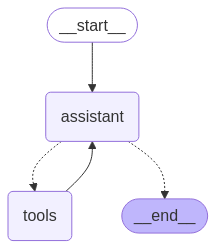

In [25]:
docs_text = """
道具名稱	功能
引路天使	它可以告訴你最好的路，不至於在路上出意外。
雲朵凝固瓦斯	使用這個瓦斯的話，雲會凝固，變得可以奔走在雲上。
交換繩	兩人同時握住繩索的話，心還是一樣，但身體替換。
室內旅行機	可以顯示出各種地點的立體影像，但室內面積並不會隨之更動。會讓自己的家有旅行的味道。
落難神明	是一個難看老機器人。不過，幫助他的話，可以滿足3個請求。
南北極徽章	只要將自己與另外一個人貼上寫有「Ｎ」或「Ｓ」的徽章，就會變的像磁鐵一樣，同極相斥，異極相吸。
間諜工具組合	能用監視器看間諜人偶的「麥克風」和「」偵察的影像。
聲音糖果	只要利用這個錄製聲音，再給別人吃下去以後， 就可以得到被錄製聲音的特徵。
進化退化放射線槍	被這光照射到，動物就可以進化(或是退化)。
算了算了棒	用這個棒子將正在生氣的人的嘴巴堵住，並說「算了，算了」，那人氣就消了。
助興樂團	這兩個道具都是人型玩偶，都會播放音樂，讓氣氛變好；不同的是，只要讓小型插秧姑娘唱歌，就可以快速地完成插秧。
四次元口袋	哆啦A夢的道具都是放在這裡面的。四次元空間是個沒有大小的空間，要多大有多大。
美食桌巾	它可以幫你做出好吃的料理。無論甚麼料理都可以變出來。
愛神之箭	被箭射中的人，會對射箭的人產生好感。
感動麥克風	使用這個麥克風，發出的聲音就會讓人感動不已。
桃太郎丸子	讓動物吃下，他會對你言聽計從。
樵夫之泉	把東西丟到這個泉裡，女神就會出現。如果你說了實話，他就會給你一個更好、更新的東西。
更衣照相機	選擇合適的衣服，拍攝一下馬上就能穿在身上。
穿透環	可以穿過任何障礙。
如果電話亭	「如果這個世界是……」只要這樣對著話筒說話，就可以創造出你所說出的世界。但是當取消時，世界將會變成「平行世界」，雙方沒有瓜葛。
翻譯蒟蒻	吃了這個蒟蒻，任何人說的任何話，我們都可以聽懂、而且可以溝通。
縮小燈	被光照射到，東西會變小。
記憶麵包	只要吃下這個吐司，就能非常容易的記住事前寫在吐司上的事物。
時光布	包了的東西既可以變新，也可以變舊。
竹蜻蜓	是最常被哆啦A夢使用的道具！只要把它放置在身體任何部分，就可依自己意思在天空中翱翔。內藏超小型電池，可時速 80 公里連續飛行 8 小時。若是間斷飛行，還可撐更久！
時光機	除了時間移動之外，它也可以用來空間與空間間的互相移動。
任意門	只要心中想著想去的地點，電腦就會傳達並歪曲所在地與目的地間的空間而將兩地靠攏，跨過門就可以到達。但是不能去距離十光年以上的行星，或者是電腦地圖上沒有的地區。是很常用的道具，使用率位列第三，僅次於竹蜻蜓、時光機。

"""

In [28]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import Document

# Split text into rows by newlines and create documents
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=1000,
    chunk_overlap=0
)

# Parse the text into rows
rows = [row.strip() for row in docs_text.split("\n") if row.strip()]

# Create documents from rows that contain tab separator
documents = []
for row in rows:
    if "\t" in row:
        name, desc = row.split("\t")
        if name != "道具名稱": # Skip header row
            doc = Document(
                page_content=name + ':' + desc,
                metadata={"name": name}
            )
            documents.append(doc)

# Create vector store
embeddings = OpenAIEmbeddings()
vector_store = Chroma.from_documents(documents, embeddings)

In [32]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 定義搜尋向量資料庫的函數
def search_doraemon_tools(query: str, k: int = 1):
    """
    搜尋哆啦A夢道具資料庫中最相似的文本

    參數:
        query (str): 搜尋的句子
        k (int): 要回傳的結果數量，預設為1

    回傳:
        list: 包含最相似文本的列表
    """
    # 使用向量資料庫進行相似度搜尋
    results = vector_store.similarity_search(query, k=k)

    # 回傳搜尋結果的文本內容
    return [doc.page_content for doc in results]

# 定義工具
from langchain.tools import Tool

# 建立搜尋工具
doraemon_search_tool = Tool(
    name="search_doraemon_tools",
    description="當需要搜尋哆啦A夢道具相關資訊時使用此工具。輸入要搜尋的句子，會回傳最相關的道具描述。",
    func=lambda q: search_doraemon_tools(q)[0]
)

# 將工具加入工具列表
tools = [doraemon_search_tool]

from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1-mini")

# Node
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

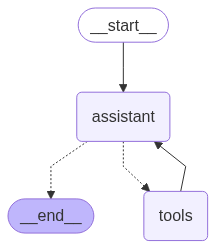

In [33]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [34]:
messages = [HumanMessage(content="任意門可以幹嘛")]
messages = react_graph.invoke({"messages": messages})
messages

{'messages': [HumanMessage(content='任意門可以幹嘛', additional_kwargs={}, response_metadata={}, id='c4902ce1-1562-40e0-85cd-9c940d953b83'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p9xcbFHbb2TaMvjAwLeNrHpQ', 'function': {'arguments': '{"__arg1":"任意門"}', 'name': 'search_doraemon_tools'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 105, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-Bk2D67GpFZjSRa5bzGCbjVcpnWWrX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8dfcc11f-7ef0-44c3-a1bb-5f6da9204477-0', tool_calls=[{'name': 'search_doraemon_tools', 'args': {'__arg1': '任意門'}, 'id': 'call